In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
import regionmask

In [24]:
ds = xr.open_dataset('/home/alonsor/predictia_projects/data/pr_1980-2015_Winter.nc')
ds


<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 144)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2015-12-01
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-28 11:17:48 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
dr = ds['tp']

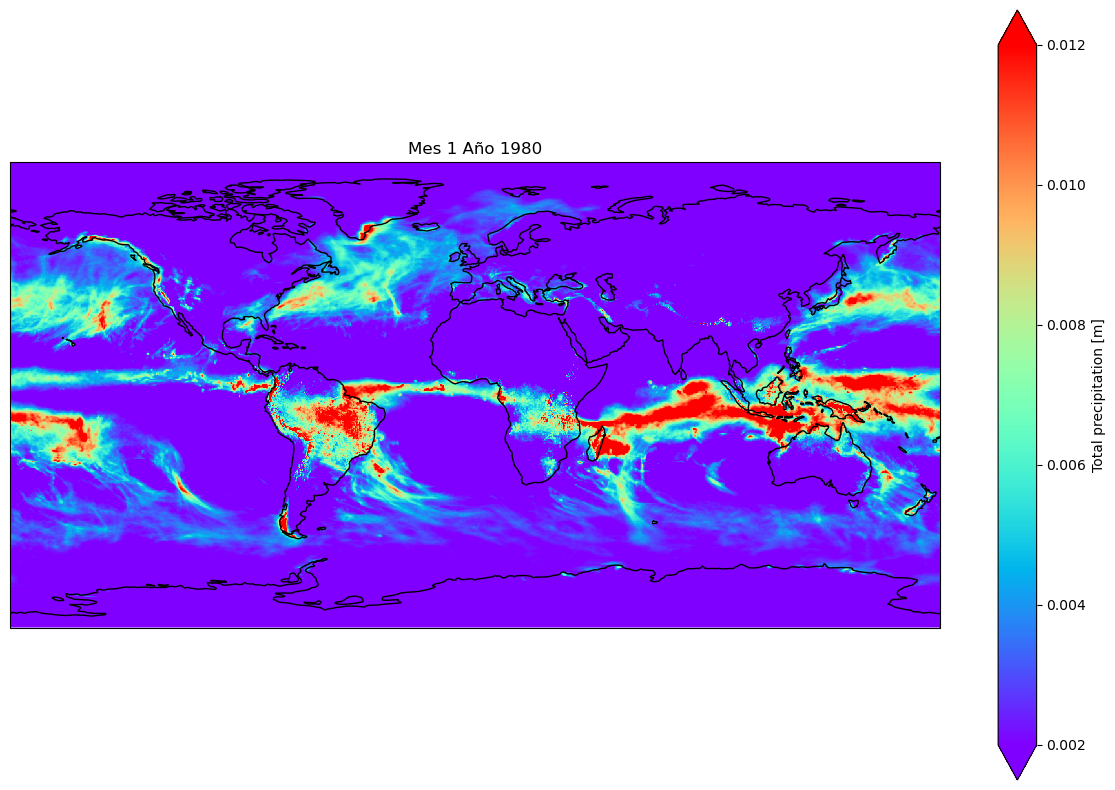

In [22]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=0).plot.pcolormesh(ax=ax, vmin = 0.002, vmax = 0.012, cmap='rainbow')
ax.coastlines()
k = 0
plt.title('Mes ' + str(dr.isel(time=k).time.dt.month.values) + ' Año ' + str(dr.isel(time=k).time.dt.year.values))
plt.gcf().set_size_inches(15, 10)


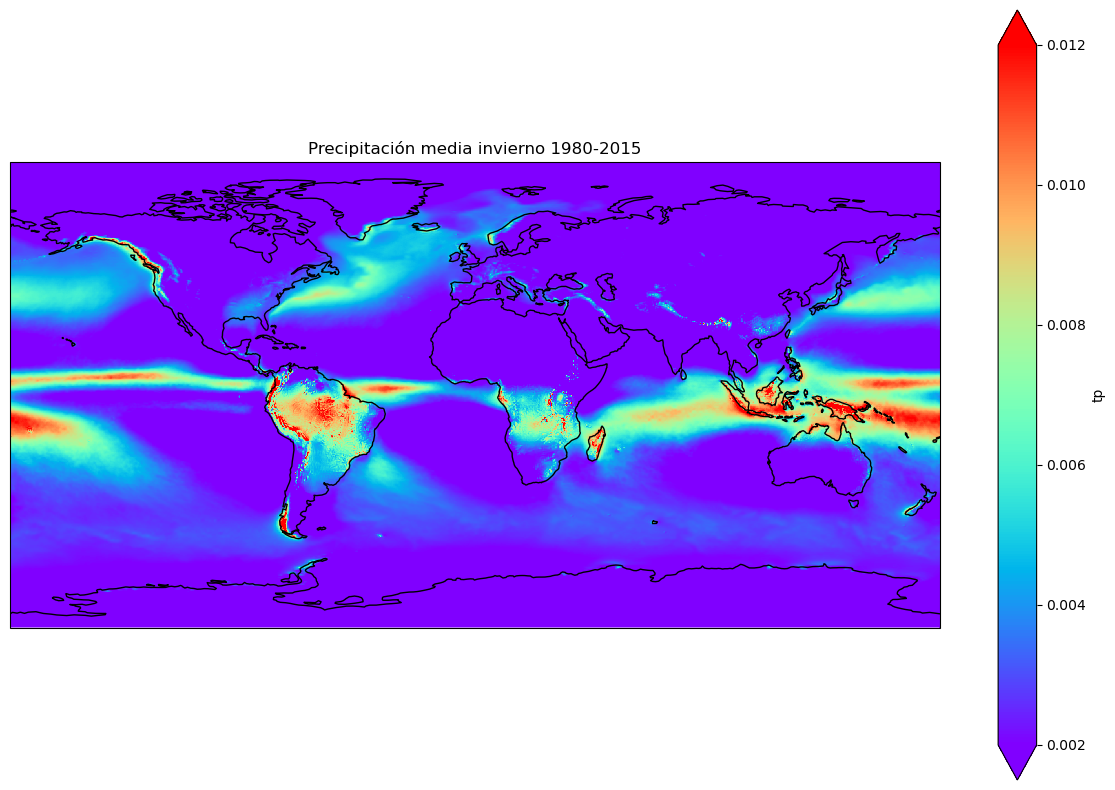

In [17]:
dr_mean = dr.mean(dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())
dr_mean.plot.pcolormesh(ax=ax, vmin = 0.002, vmax= 0.012, cmap='rainbow')
ax.coastlines()
plt.title('Precipitación media invierno 1980-2015')
plt.gcf().set_size_inches(15, 10)

In [7]:
ar6 = regionmask.defined_regions.ar6.all
mask = ar6.mask(ds['longitude'], ds['latitude'])
region_masked = dr.where(mask == 19)
mean_pr = region_masked.mean(dim = 'time')

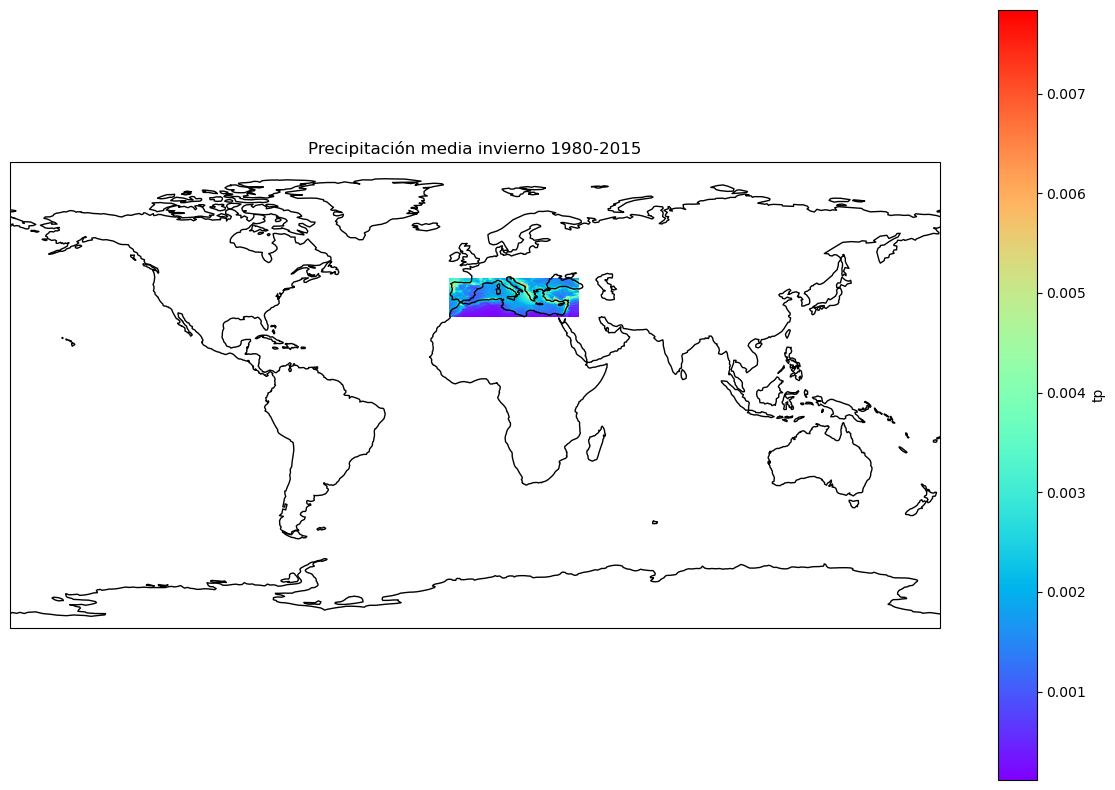

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
mean_pr.plot.pcolormesh(ax=ax , cmap='rainbow')
ax.coastlines()
plt.title('Precipitación media invierno 1980-2015')
plt.gcf().set_size_inches(15, 10)

In [9]:
# Se cambian los valores de longitud de 0-360 a -180-180
region_masked["longitude"] = (region_masked["longitude"] + 180) % 360 - 180

In [10]:
# Se buscan los valores (no NaN) de latitud y longitud mínimos y máximos para fijar los límites del mapa
lon_min = region_masked["longitude"].where(~region_masked.isnull()).min().values
lon_max = region_masked["longitude"].where(~region_masked.isnull()).max().values
lat_min = region_masked["latitude"].where(~region_masked.isnull()).min().values
lat_max = region_masked["latitude"].where(~region_masked.isnull()).max().values

lon_min, lon_max, lat_min, lat_max

(array(-9.75), array(40.), array(30.25), array(45.))

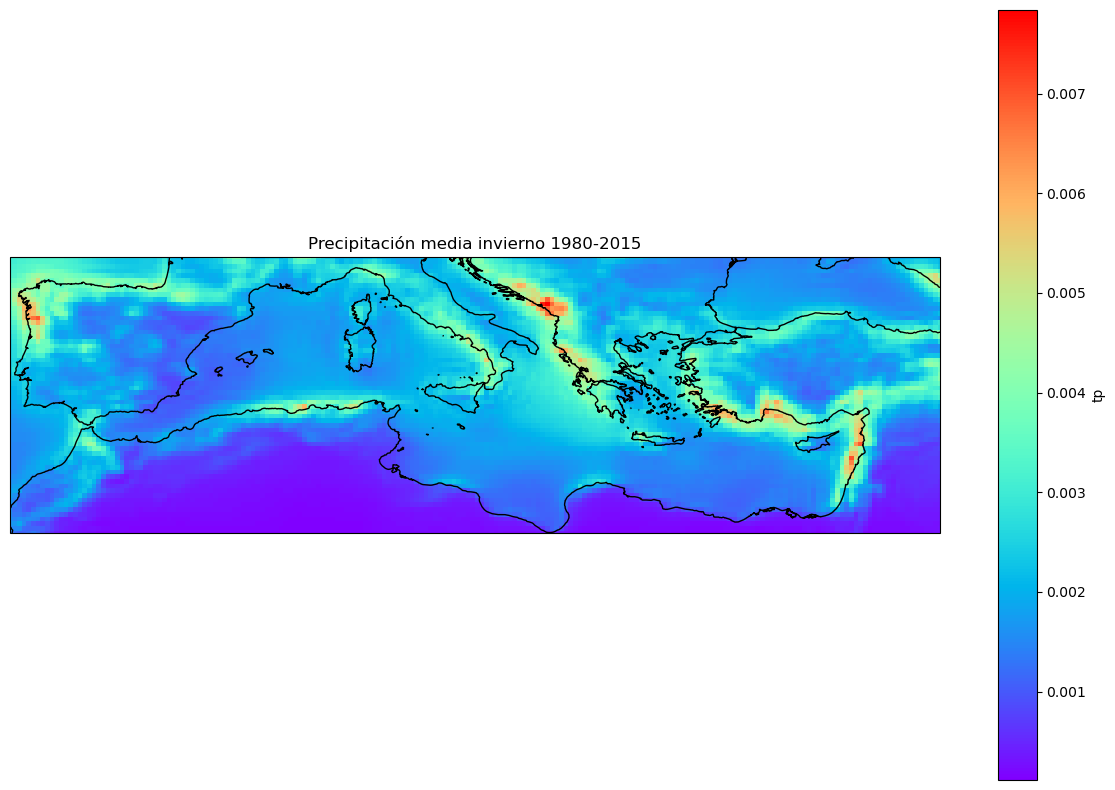

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
mean_pr.plot.pcolormesh(ax=ax , cmap='rainbow')
ax.coastlines()
plt.title('Precipitación media invierno 1980-2015')
plt.gcf().set_size_inches(15, 10)

## SERIE TEMPORAL / AGREGACIÓN ESPACIAL

In [41]:
# Calcular pesos basados en la latitud
weights = np.cos(np.deg2rad(dr["latitude"]))

In [42]:
# Resample a nivel anual ("Y) y se suma la precipitación
region_masked_anual = region_masked.resample(time="Y").mean()
region_masked_anual

<xarray.DataArray 'tp' (time: 36, latitude: 721, longitude: 1440)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... -1.0 -0.75 -0.5 -0.25
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-12-31 1981-12-31 ... 2015-12-31
Attributes:
    units:      m
    long_name:  Total precipitation

In [43]:
# Se hace una media ponderada por la latitud
region_masked_anual_weighted = region_masked_anual.weighted(weights).mean(("latitude", "longitude"))

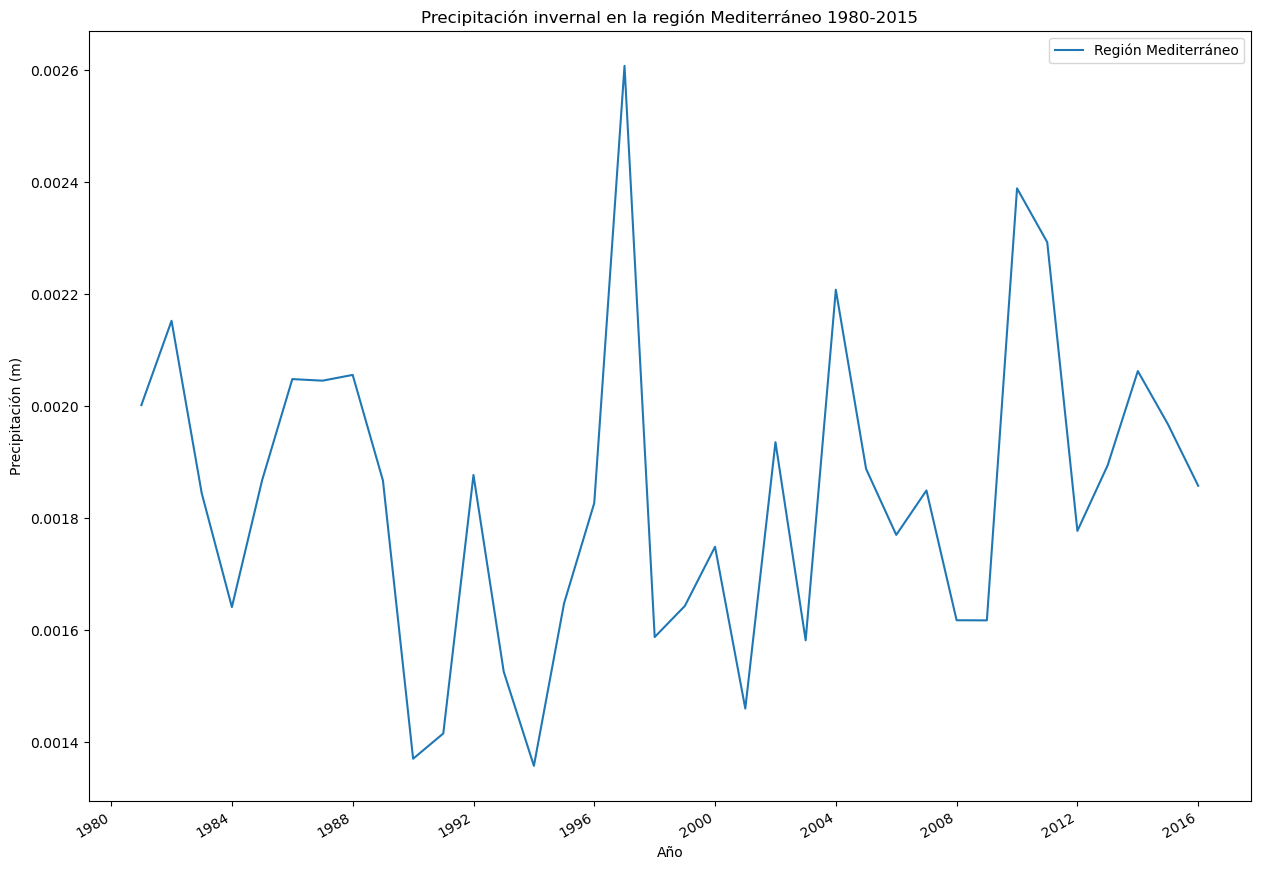

In [44]:
f, ax = plt.subplots()
region_masked_anual_weighted.plot.line(ax=ax, label= 'Región Mediterráneo')
ax.set_title('Precipitación invernal en la región Mediterráneo 1980-2015')
ax.set_ylabel('Precipitación (m)')
ax.set_xlabel('Año')
ax.legend()
plt.gcf().set_size_inches(15, 10)